### 问题1、数据分析与故障特征提取：请考虑目标域的迁移任务，从提供的源域数据中筛选部分数据组成数据集。结合轴承故障机理，选择合适的方法或指标对有代表性的源域数据进行特征分析，并对整体数据集进行特征提取，用于后续诊断任务。（源域数据可选用其他公开轴承数据集，但应标明出处）。
首先，需要对给定的轴承试验台振动数据进行系统的预处理与特征分析，以为后续迁移学习提供稳健的源域表征。考虑到目标域数据的采样频率与列车实际转速特性，首先将源域12 kHz与48 kHz采样的原始信号统一重采样至与目标域32 kHz相匹配的带宽，并进行去趋势与带通滤波，以消除低频漂移及高频环境噪声。在此基础上，结合轴承故障机理提取多维度特征：一方面，在时域中计算均方根值、峭度、峰值因子等统计指标以表征冲击脉冲强度；另一方面，在频域通过Hilbert包络解调获取包络谱，并计算与BPFI、BPFO及BSF等理论故障特征频率及其旁带相关的幅值与能量占比，以捕捉局部缺陷所引起的周期性冲击。

---

# 0) 记号与预处理

* 离散振动信号：$\{x_i\}_{i=1}^N$，采样率 $f_s$；
* Hilbert 包络：$e_i = |\tilde x_i|$，其中 $\tilde x$ 为 $x$ 的解析信号；
* 频率网格：$f_k=\tfrac{k}{N}f_s$（$k=0,\dots,\lfloor N/2\rfloor$），频率分辨率 $\Delta f=f_s/N$；
* 包络谱幅度：$|E(f_k)|$（对去直流的包络做 FFT 后的模值）。

> 解释：脚本先对整段信号做去趋势、带通滤波（抑制漂移/噪声）、再重采样到 32 kHz；其后在**整段**上计算以下特征（不再分滑动窗口）。

---

# 1) 时域统计（整段）

## 均值（Mean）

$$
\mu=\frac{1}{N}\sum_{i=1}^N x_i
$$

解释：信号的平均水平（直流分量），可反映传感器偏置或缓慢漂移；理想振动的 $\mu$ 应接近 0。

## 标准差（Std）

$$
\sigma=\sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_i-\mu)^2}
$$

解释：总体波动强度的度量；越大表示总体振动越“活跃”。

## 均方根（RMS）

$$
\mathrm{RMS}=\sqrt{\frac{1}{N}\sum_{i=1}^N x_i^2}
$$

解释：等效能量强度的标准指标；旋转机械的振动等级评估常用 RMS。

## 峭度（Kurtosis）

$$
K=\frac{1}{N}\sum_{i=1}^N \frac{(x_i-\mu)^4}{\sigma^4}
$$

解释：对“尖峰/冲击”极为敏感；早期局部缺陷会引入脉冲，导致 $K$ 明显升高。

## 偏度（Skewness）

$$
S=\frac{1}{N}\sum_{i=1}^N \frac{(x_i-\mu)^3}{\sigma^3}
$$

解释：分布左右不对称性；存在偏置或不对称冲击时，$S$ 偏离 0。

## 峰值（Peak）

$$
P=\max_{1\le i\le N}|x_i|
$$

解释：瞬时最大幅值；异常冲击或拍击会拉高 $P$。

## 峰值因子（Crest Factor）

$$
\mathrm{CF}=\frac{P}{\mathrm{RMS}}
$$

解释：衡量尖峰相对整体能量的程度；冲击越强、$\mathrm{CF}$ 越大。

## 脉冲因子（Impulse Factor）

$$
\mathrm{IF}=\frac{P}{\frac{1}{N}\sum_{i=1}^N |x_i|}
$$

解释：峰值与平均绝对幅值之比；对稀疏但剧烈的脉冲更敏感。

## 形状因子（Shape Factor）

$$
\mathrm{SF}=\frac{\mathrm{RMS}}{\frac{1}{N}\sum_{i=1}^N |x_i|}
$$

解释：RMS 相对平均幅值的比例；反映波形“尖锐/平滑”的整体形态。

## 间隙因子（Clearance Factor）

$$
\mathrm{CLF}=\frac{P}{\left(\frac{1}{N}\sum_{i=1}^N \sqrt{|x_i|}\right)^2}
$$

解释：强调尖峰对低阶统计的支配程度；对微小局部缺陷的早期冲击尤敏感。

---

# 2) 频域统计（整段）

## DFT、功率谱与归一化功率谱

$$
X_k=\sum_{i=1}^N x_i\,e^{-j2\pi (k-1)(i-1)/N},\qquad
P_k=\frac{|X_k|^2}{N},\qquad
p_k=\frac{P_k}{\sum_u P_u}
$$

解释：$X_k$ 为频域复幅，$P_k$ 近似功率谱密度；$p_k$ 为能量分布的概率化刻画，用于频谱统计。

## 主频（Dominant Frequency）

$$
f_{\mathrm{dom}}=f_{k^*},\quad k^*=\arg\max_k |X_k|
$$

解释：幅值最大的频率分量；常对应主要转动/共振成分。

## 谱质心（Spectral Centroid）

$$
C=\sum_k f_k\,p_k
$$

解释：能量“重心”位置；越大表示能量偏高频。

## 谱熵（Spectral Entropy）

$$
H=-\sum_k p_k\ln p_k
$$

解释：频谱“均匀/无序”的程度；平坦谱（信息多）时大，谱集中（单调制）时小。

## 谱带宽（Spectral Bandwidth）

$$
B=\sqrt{\sum_k (f_k-C)^2\,p_k}
$$

解释：能量相对谱质心的离散度；频带越宽、带宽越大。

---

# 3) 包络域统计（整段）

## 包络信号与包络 RMS、包络峭度

$$
e_i=|\tilde x_i|,\qquad
\mathrm{RMS}_e=\sqrt{\frac{1}{N}\sum_{i=1}^N e_i^2},\qquad
K_e=\frac{1}{N}\sum_{i=1}^N \frac{(e_i-\bar e)^4}{\sigma_e^4}
$$

解释：Hilbert 包络凸显冲击产生的调幅分量；$\mathrm{RMS}_e$ 表示包络能量，$K_e$ 对周期性冲击的尖锐度极敏感。

---

# 4) 轴承几何特征频率（$\phi\simeq 0^\circ$）

设轴转速 $\mathrm{RPM}$，轴转频

$$
f_r=\frac{\mathrm{RPM}}{60},
$$

滚动体数 $N_d$，滚动体直径 $d$，节径 $D$，记 $\rho=\tfrac{d}{D}$。

## 保持架特征频率（FTF）

$$
\mathrm{FTF}=\tfrac{1}{2}(1-\rho)\,f_r
$$

解释：保持架绕轴的公转频率；保持架缺陷或强调制时，FTF 及其倍频明显。

## 外圈特征频率（BPFO）

$$
\mathrm{BPFO}=\tfrac{N_d}{2}(1-\rho)\,f_r
$$

解释：外圈固定在座，滚动体周期撞击外圈缺陷形成 $\mathrm{BPFO}$；**OR** 故障在包络谱上易见其倍频与边带。

## 内圈特征频率（BPFI）

$$
\mathrm{BPFI}=\tfrac{N_d}{2}(1+\rho)\,f_r
$$

解释：滚动体周期撞击旋转的内圈缺陷形成 $\mathrm{BPFI}$；**IR** 故障常伴更强的转速相关边带。

## 滚动体特征频率（BSF）

$$
\mathrm{BSF}=\frac{1-\rho^2}{2\rho}\,f_r
$$

解释：滚动体自转/滑移与缺陷接触的特征频率；**B** 故障在 $\mathrm{BSF}$ 及邻近倍频处出现峰，但受滑移影响更分散。

> 代码自动按通道选用几何（DE=SKF6205，FE=SKF6203），并用文件内 RPM 均值换算 $f_r$。

---

# 5) 包络谱对齐指标（在 $|E(f)|$ 上）

## 总能量与带内索引

$$
E_{\text{tot}}=\sum_k |E(f_k)|^2\,\Delta f,\qquad
\mathcal I(f_0)=\{k:\ |f_k-f_0|\le \delta\}
$$

解释：$E_{\text{tot}}$ 是包络谱的总能量；$\mathcal I(f_0)$ 是以 $f_0$ 为中心、宽度 $\pm\delta$ Hz 的频带索引（默认 $\delta=2$ Hz）。

## 带内峰值（Peak）

$$
\mathrm{Peak}(f_0)=\max_{k\in \mathcal I(f_0)} |E(f_k)|
$$

解释：理论频率附近的最大幅值；直接反映该故障线的“突出程度”。

## 带内能量（BandE）

$$
\mathrm{BandE}(f_0)=\sum_{k\in \mathcal I(f_0)} |E(f_k)|^2\,\Delta f
$$

解释：理论频率附近的局部能量；比峰值更稳健，抗单点噪声。

## 能量占比（Eratio）

$$
\mathrm{Eratio}(f_0)=\frac{\mathrm{BandE}(f_0)}{E_{\text{tot}}}
$$

解释：把局部能量相对化（0–1 量纲）；便于跨样本比较强弱。

## 倍频能量与倍频占比（HarmE / HarmRatio）

$$
\mathrm{HarmE}_M(f_0)=\sum_{m=1}^{M}\mathrm{BandE}(m f_0),\qquad
\mathrm{HarmRatio}_M(f_0)=\frac{\mathrm{HarmE}_M(f_0)}{E_{\text{tot}}}
$$

解释：聚合前 $M$ 个倍频（默认 $M=5$）的能量及其相对量；故障越严重，倍频能量常呈系统性增强。

## 边带能量与边带比（SB / SBI）

$$
\mathrm{SB}_Q(f_0)=\sum_{m=1}^{M}\sum_{q=1}^{Q}
\Big[\mathrm{BandE}(m f_0-q f_r)+\mathrm{BandE}(m f_0+q f_r)\Big]
$$

解释：以转频 $f_r$ 为步距，统计各倍频两侧前 $Q$ 阶（默认 $Q=3$）**调制边带**的能量总和；外圈/内圈缺陷常有显著边带。

$$
\mathrm{SBI}_Q(f_0)=\frac{\mathrm{SB}_Q(f_0)}{\mathrm{HarmE}_M(f_0)+\varepsilon}\quad(\varepsilon>0)
$$

解释：边带能量相对于倍频主能量的比例（调制强度指标）；越大表示**转频调制**越显著，常用于区分 OR/IR 场景。




In [4]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
## 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

In [5]:
# ==== Jupyter cell: 每个Excel -> 一条记录（整段特征 + 几何频率对齐）====

from pathlib import Path
import os, re, math, warnings
import numpy as np
import pandas as pd
from scipy import signal, stats
from typing import Dict, List, Optional

# ---------------- 基础配置 ----------------
ROOT = r"D:\Users\Administrator\Desktop\2025研赛E题\源域数据集"      # 顶层目录：放着各子文件夹/Excel 同名文件
TARGET_FS = 32000                # 重采样目标采样率
DEFAULT_FS_GUESS = 12000         # 推断不到采样率时的默认值
BP_LOW, BP_HIGH = 500.0, 16000.0 # 带通滤波带宽（Hz）
FILTER_ORDER = 4
READ_GLOB = ("*.xlsx",)
SAVE_PATH = "features_aggregated_perfile.csv"

CHANNEL_PATTERNS = [r"DE[_\- ]?time", r"FE[_\- ]?time", r"BA[_\- ]?time"]
RPM_PATTERNS = [r"rpm$", r"^rpm", r"_rpm", r"X\d+RPM"]

# ---- 轴承几何（英寸） ----
GEOM = {
    "DE": {"Nd": 9, "d": 0.3126, "D": 1.537},  # SKF6205
    "FE": {"Nd": 9, "d": 0.2656, "D": 1.122},  # SKF6203
}

# ---- 文件名标签解析 ----
LABEL_RE = re.compile(
    r"(?P<cls>OR|IR|B|N)"
    r"(?P<size>\d{3})?"
    r"(?:@(?P<pos>(3|6|12)))?"
    r"(?:_(?P<load>\d))?",
    re.IGNORECASE
)

def parse_label_from_name(path: Path) -> dict:
    name = path.stem.upper()
    m = LABEL_RE.search(name)
    out = {"cls": None, "size_in": None, "load_hp": None, "or_pos": None}
    if m:
        cls = m.group("cls").upper()
        out["cls"] = cls
        size = m.group("size")
        out["size_in"] = float(size)/1000.0 if (size and cls in {"OR","IR","B"}) else None
        ld = m.group("load")
        out["load_hp"] = int(ld) if ld is not None else None
        pos = m.group("pos")
        out["or_pos"] = int(pos) if (pos and cls=="OR") else None
    return out

# ---- 辅助：采样率/滤波/重采样/列匹配 ----
def infer_fs_from_path(path: Path, default_fs=DEFAULT_FS_GUESS) -> int:
    s = str(path).lower()
    if re.search(r"(48k|48000)", s): return 48000
    if re.search(r"(12k|12000)", s): return 12000
    return default_fs

def butter_bandpass(low, high, fs, order=4):
    nyq = 0.5*fs
    low_n, high_n = max(1e-9, low/nyq), min(0.999999, high/nyq)
    if high_n <= low_n: high_n = min(0.999999, low_n*1.5)
    b, a = signal.butter(order, [low_n, high_n], btype='band')
    return b, a

def preprocess_whole(x: np.ndarray, fs_in: int, fs_out: int) -> np.ndarray:
    x = signal.detrend(np.asarray(x, dtype=float), type="linear")
    b, a = butter_bandpass(BP_LOW, min(BP_HIGH, 0.49*fs_in), fs=fs_in, order=FILTER_ORDER)
    x = signal.filtfilt(b, a, x, method="gust")
    g = math.gcd(fs_in, fs_out)
    up, down = fs_out//g, fs_in//g
    return signal.resample_poly(x, up=up, down=down, padtype="line")

def find_columns_by_patterns(df: pd.DataFrame, patterns: List[str]) -> List[str]:
    cols=[]
    for p in patterns:
        rg = re.compile(p, re.IGNORECASE)
        cols += [c for c in df.columns if rg.search(str(c))]
    uniq=[]; seen=set()
    for c in cols:
        if c not in seen:
            seen.add(c); uniq.append(c)
    return uniq

def maybe_read_rpm(df: pd.DataFrame) -> Optional[float]:
    cols = find_columns_by_patterns(df, RPM_PATTERNS)
    if not cols: return None
    s = pd.to_numeric(df[cols[0]], errors="coerce").dropna()
    return float(s.mean()) if len(s) else None

# ---- 基础特征（整段） ----
def time_features(x: np.ndarray) -> Dict[str, float]:
    x = np.asarray(x, dtype=float); N=len(x)
    if N==0:
        return dict(mean=np.nan,std=np.nan,rms=np.nan,kurtosis=np.nan,skewness=np.nan,
                    peak=np.nan,crest_factor=np.nan,impulse_factor=np.nan,
                    shape_factor=np.nan,clearance_factor=np.nan)
    mean=float(np.mean(x))
    std=float(np.std(x, ddof=1)) if N>1 else 0.0
    rms=float(np.sqrt(np.mean(x**2)))
    kurt=float(stats.kurtosis(x, fisher=False, bias=False)) if N>3 else np.nan
    skew=float(stats.skew(x, bias=False)) if N>2 else np.nan
    peak=float(np.max(np.abs(x)))
    mean_abs=float(np.mean(np.abs(x)))
    sqrt_mean_abs=float(np.sqrt(np.mean(np.sqrt(np.abs(x))**2)))
    cf=peak/(rms+1e-12); imp=peak/(mean_abs+1e-12)
    shp=rms/(mean_abs+1e-12); clr=peak/(sqrt_mean_abs+1e-12)
    return dict(mean=mean,std=std,rms=rms,kurtosis=kurt,skewness=skew,peak=peak,
                crest_factor=cf,impulse_factor=imp,shape_factor=shp,clearance_factor=clr)

def spectral_features(x: np.ndarray, fs: int) -> Dict[str, float]:
    X = np.fft.rfft(x); freqs=np.fft.rfftfreq(len(x), d=1/fs)
    mag = np.abs(X)+1e-12
    ps = mag**2; psn = ps/ps.sum()
    idx=int(np.argmax(mag)); dom=float(freqs[idx])
    cent=float((freqs*psn).sum())
    sent=float(-(psn*np.log(psn)).sum())
    bw=float(np.sqrt(((freqs-cent)**2*psn).sum()))
    return dict(dom_freq=dom,spec_centroid=cent,spec_entropy=sent,spec_bandwidth=bw)

def envelope_and_spectrum(x: np.ndarray, fs: int):
    analytic = signal.hilbert(x)
    env = np.abs(analytic)
    e = env - np.mean(env)
    X = np.fft.rfft(e)
    mag = np.abs(X)
    freqs = np.fft.rfftfreq(len(e), d=1/fs)
    return env, mag, freqs

def envelope_features(x: np.ndarray, fs: int) -> Dict[str, float]:
    env = np.abs(signal.hilbert(x))
    env_rms=float(np.sqrt(np.mean(env**2)))
    env_kurt=float(stats.kurtosis(env, fisher=False, bias=False)) if len(env)>3 else np.nan
    return dict(env_rms=env_rms, env_kurtosis=env_kurt)

# ---- 几何频率 + 对齐指标（包络谱上） ----
def bearing_freqs(fr_hz: float, Nd: int, d: float, D: float) -> dict:
    rho = d / D
    ftf  = 0.5 * (1 - rho) * fr_hz
    bpfo = 0.5 * Nd * (1 - rho) * fr_hz
    bpfi = 0.5 * Nd * (1 + rho) * fr_hz
    bsf  = (1 - rho**2) / (2*rho) * fr_hz
    return {"fr": fr_hz, "FTF": ftf, "BPFO": bpfo, "BPFI": bpfi, "BSF": bsf, "rho": rho}

def band_metrics(freqs, mag, f0, delta=2.0):
    idx = np.where((freqs >= f0 - delta) & (freqs <= f0 + delta))[0]
    if idx.size==0: return 0.0, 0.0
    peak = float(mag[idx].max())
    df = float(freqs[1]-freqs[0]) if len(freqs)>1 else 1.0
    energy = float((mag[idx]**2).sum() * df)
    return peak, energy

def harmonic_energy(freqs, mag, f0, M=5, delta=2.0):
    e=0.0
    for m in range(1, M+1):
        _, ei = band_metrics(freqs, mag, m*f0, delta)
        e += ei
    return e

def sideband_energy(freqs, mag, f0, fr, M=5, Q=3, delta=2.0):
    e=0.0
    for m in range(1, M+1):
        base = m*f0
        for q in range(1, Q+1):
            for sign in (-1, +1):
                _, ei = band_metrics(freqs, mag, base + sign*q*fr, delta)
                e += ei
    return e

def freq_aligned_indicators(env_mag, freqs, fr, targets: dict,
                            delta=2.0, M=5, Q=3, prefix=""):
    total_energy = float((env_mag**2).sum() * (freqs[1]-freqs[0] if len(freqs)>1 else 1.0))
    out = {}
    for key in ["FTF","BPFO","BPFI","BSF"]:
        f0 = targets[key]
        pk, be = band_metrics(freqs, env_mag, f0, delta)
        he = harmonic_energy(freqs, env_mag, f0, M, delta)
        sb = sideband_energy(freqs, env_mag, f0, fr, M, Q, delta)
        out[f"{prefix}{key}_peak"] = pk
        out[f"{prefix}{key}_bandE"] = be
        out[f"{prefix}{key}_Eratio"] = be / (total_energy + 1e-12)
        out[f"{prefix}{key}_harmE_M{M}"] = he
        out[f"{prefix}{key}_harmRatio_M{M}"] = he / (total_energy + 1e-12)
        out[f"{prefix}{key}_SB_Q{Q}"] = sb
        out[f"{prefix}{key}_SBI_Q{Q}"] = sb / (he + 1e-12)
    return out

# ---------------- 主流程：每文件 -> 一行 ----------------
rows = []

root_path = Path(ROOT).expanduser().resolve()
excel_files = []
for pat in READ_GLOB:
    excel_files += list(root_path.rglob(pat))
if not excel_files:
    print("未找到 Excel 文件，请检查 ROOT/READ_GLOB。")

for fx in sorted(excel_files):
    meta = parse_label_from_name(fx)

    # 读取 Excel
    try:
        df = pd.read_excel(fx)
    except Exception as e:
        print(f"[READ-ERROR] {fx}: {e}")
        continue

    fs_in = infer_fs_from_path(fx, DEFAULT_FS_GUESS)
    rpm_mean = maybe_read_rpm(df)
    fr_hz = (rpm_mean/60.0) if rpm_mean is not None else np.nan

    # 找到通道列
    sig_cols = find_columns_by_patterns(df, CHANNEL_PATTERNS)
    # 若没有匹配名，退化为所有长的数值列（但仍然只取前3列作为 DE/FE/BA 的占位）
    if not sig_cols:
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        sig_cols = num_cols[:3]

    # 为当前文件组合一行特征
    row = {
        "file": str(fx),
        "fs_inferred": fs_in,
        "fs_target": TARGET_FS,
        "rpm_mean": rpm_mean,
        "fr_hz": fr_hz,
        # 标签
        "label_cls": meta["cls"],
        "label_size_in": meta["size_in"],
        "label_load_hp": meta["load_hp"],
        "label_or_pos": meta["or_pos"],
    }

    # 逐通道处理：DE / FE / BA（缺失则留 NaN）
    for col in sig_cols:
        x_raw = pd.to_numeric(df[col], errors="coerce").dropna().to_numpy()
        if len(x_raw) < max(64, int(0.2*fs_in)):
            print(f"[SHORT] {fx.name}::{col} 样本过短，跳过该列")
            continue

        colU = str(col).upper()
        if "DE" in colU:
            side = "DE"
        elif "FE" in colU:
            side = "FE"
        elif "BA" in colU:
            side = "BA"
        else:
            # 未识别的列：不做对齐指标，仅常规统计，前缀用列名
            side = None

        try:
            x_rs = preprocess_whole(x_raw, fs_in, TARGET_FS)
        except Exception as e:
            print(f"[PREPROC-ERR] {fx.name}::{col}: {e}")
            continue

        # 基本特征（整段）
        feats_t = time_features(x_rs)
        feats_f = spectral_features(x_rs, TARGET_FS)
        feats_e = envelope_features(x_rs, TARGET_FS)

        # 包络谱
        _, env_mag, fvec = envelope_and_spectrum(x_rs, TARGET_FS)

        # 前缀（列名）
        prefix = f"{('DE' if side=='DE' else 'FE' if side=='FE' else 'BA' if side=='BA' else str(col))}_"

        # 几何频率与对齐（仅 DE/FE 做）
        if side in ("DE","FE") and np.isfinite(fr_hz) and fr_hz>0:
            Nd = GEOM[side]["Nd"]; d=GEOM[side]["d"]; D=GEOM[side]["D"]
            geom = bearing_freqs(fr_hz, Nd, d, D)
            aligned = freq_aligned_indicators(env_mag, fvec, geom["fr"], geom,
                                              delta=2.0, M=5, Q=3, prefix=prefix)
            # 也记录几何频率值（便于检查）
            row[f"{prefix}FTF"] = geom["FTF"]
            row[f"{prefix}BPFO"] = geom["BPFO"]
            row[f"{prefix}BPFI"] = geom["BPFI"]
            row[f"{prefix}BSF"] = geom["BSF"]
            row[f"{prefix}rho_d_over_D"] = geom["rho"]
            row.update(aligned)

        # 写入通道统计
        row.update({f"{prefix}{k}": v for k,v in feats_t.items()})
        row.update({f"{prefix}{k}": v for k,v in feats_f.items()})
        row.update({f"{prefix}{k}": v for k,v in feats_e.items()})

    rows.append(row)
    print(f"[OK] {fx.name} -> 1 row added")

# 保存
if rows:
    out_df = pd.DataFrame(rows)
    out_df.to_csv(SAVE_PATH, index=False, encoding="utf-8")
    print(f"\nDone. Saved per-file features to: {Path(SAVE_PATH).resolve()}")
    display(out_df.head())
else:
    print("没有生成任何记录。")


未找到 Excel 文件，请检查 ROOT/READ_GLOB。
没有生成任何记录。


In [ ]:
df1 = pd.read_excel(r'D:\Users\Administrator\Desktop\2025研赛E题\源域数据集\12kHz_DE_data\B\0007\B007_0.xlsx')
df2 = pd.read_excel(r'D:\Users\Administrator\Desktop\2025研赛E题\源域数据集\12kHz_DE_data\IR\0007\IR007_0.xlsx')
df3 = pd.read_excel(r'D:\Users\Administrator\Desktop\2025研赛E题\源域数据集\12kHz_DE_data\OR\Centered\0007\OR007@6_0.xlsx')
df4 = pd.read_excel(r'D:\Users\Administrator\Desktop\2025研赛E题\源域数据集\48kHz_Normal_data\N_0.xlsx')
df1

,X118_DE_time,X118_FE_time,X118_BA_time,X118RPM
0,0.196122,-0.070966,-0.013883,1796.0
1,-0.010495,0.126681,-0.058345,NaN
2,-0.008221,-0.193211,-0.036054,NaN
3,0.197584,-0.062337,0.003137,NaN
4,0.083717,0.063607,-0.034404,NaN
...,...,...,...,...
95995,-0.056140,-0.141642,-0.059874,NaN
95996,-0.072221,-0.021246,0.020319,NaN
95997,-0.019754,0.332958,0.035730,NaN
95998,0.019068,-0.137122,-0.031024,NaN


In [ ]:
x1 = df1['X118_DE_time'].values
x2 = df2['X105_DE_time'].values
x3 = df3['X130_DE_time'].values
x4 = df4['X097_DE_time'].values
x4

array([ 0.04063871,  0.07610333,  0.08715994, ..., -0.04718837,
        0.00413102,  0.03438025])

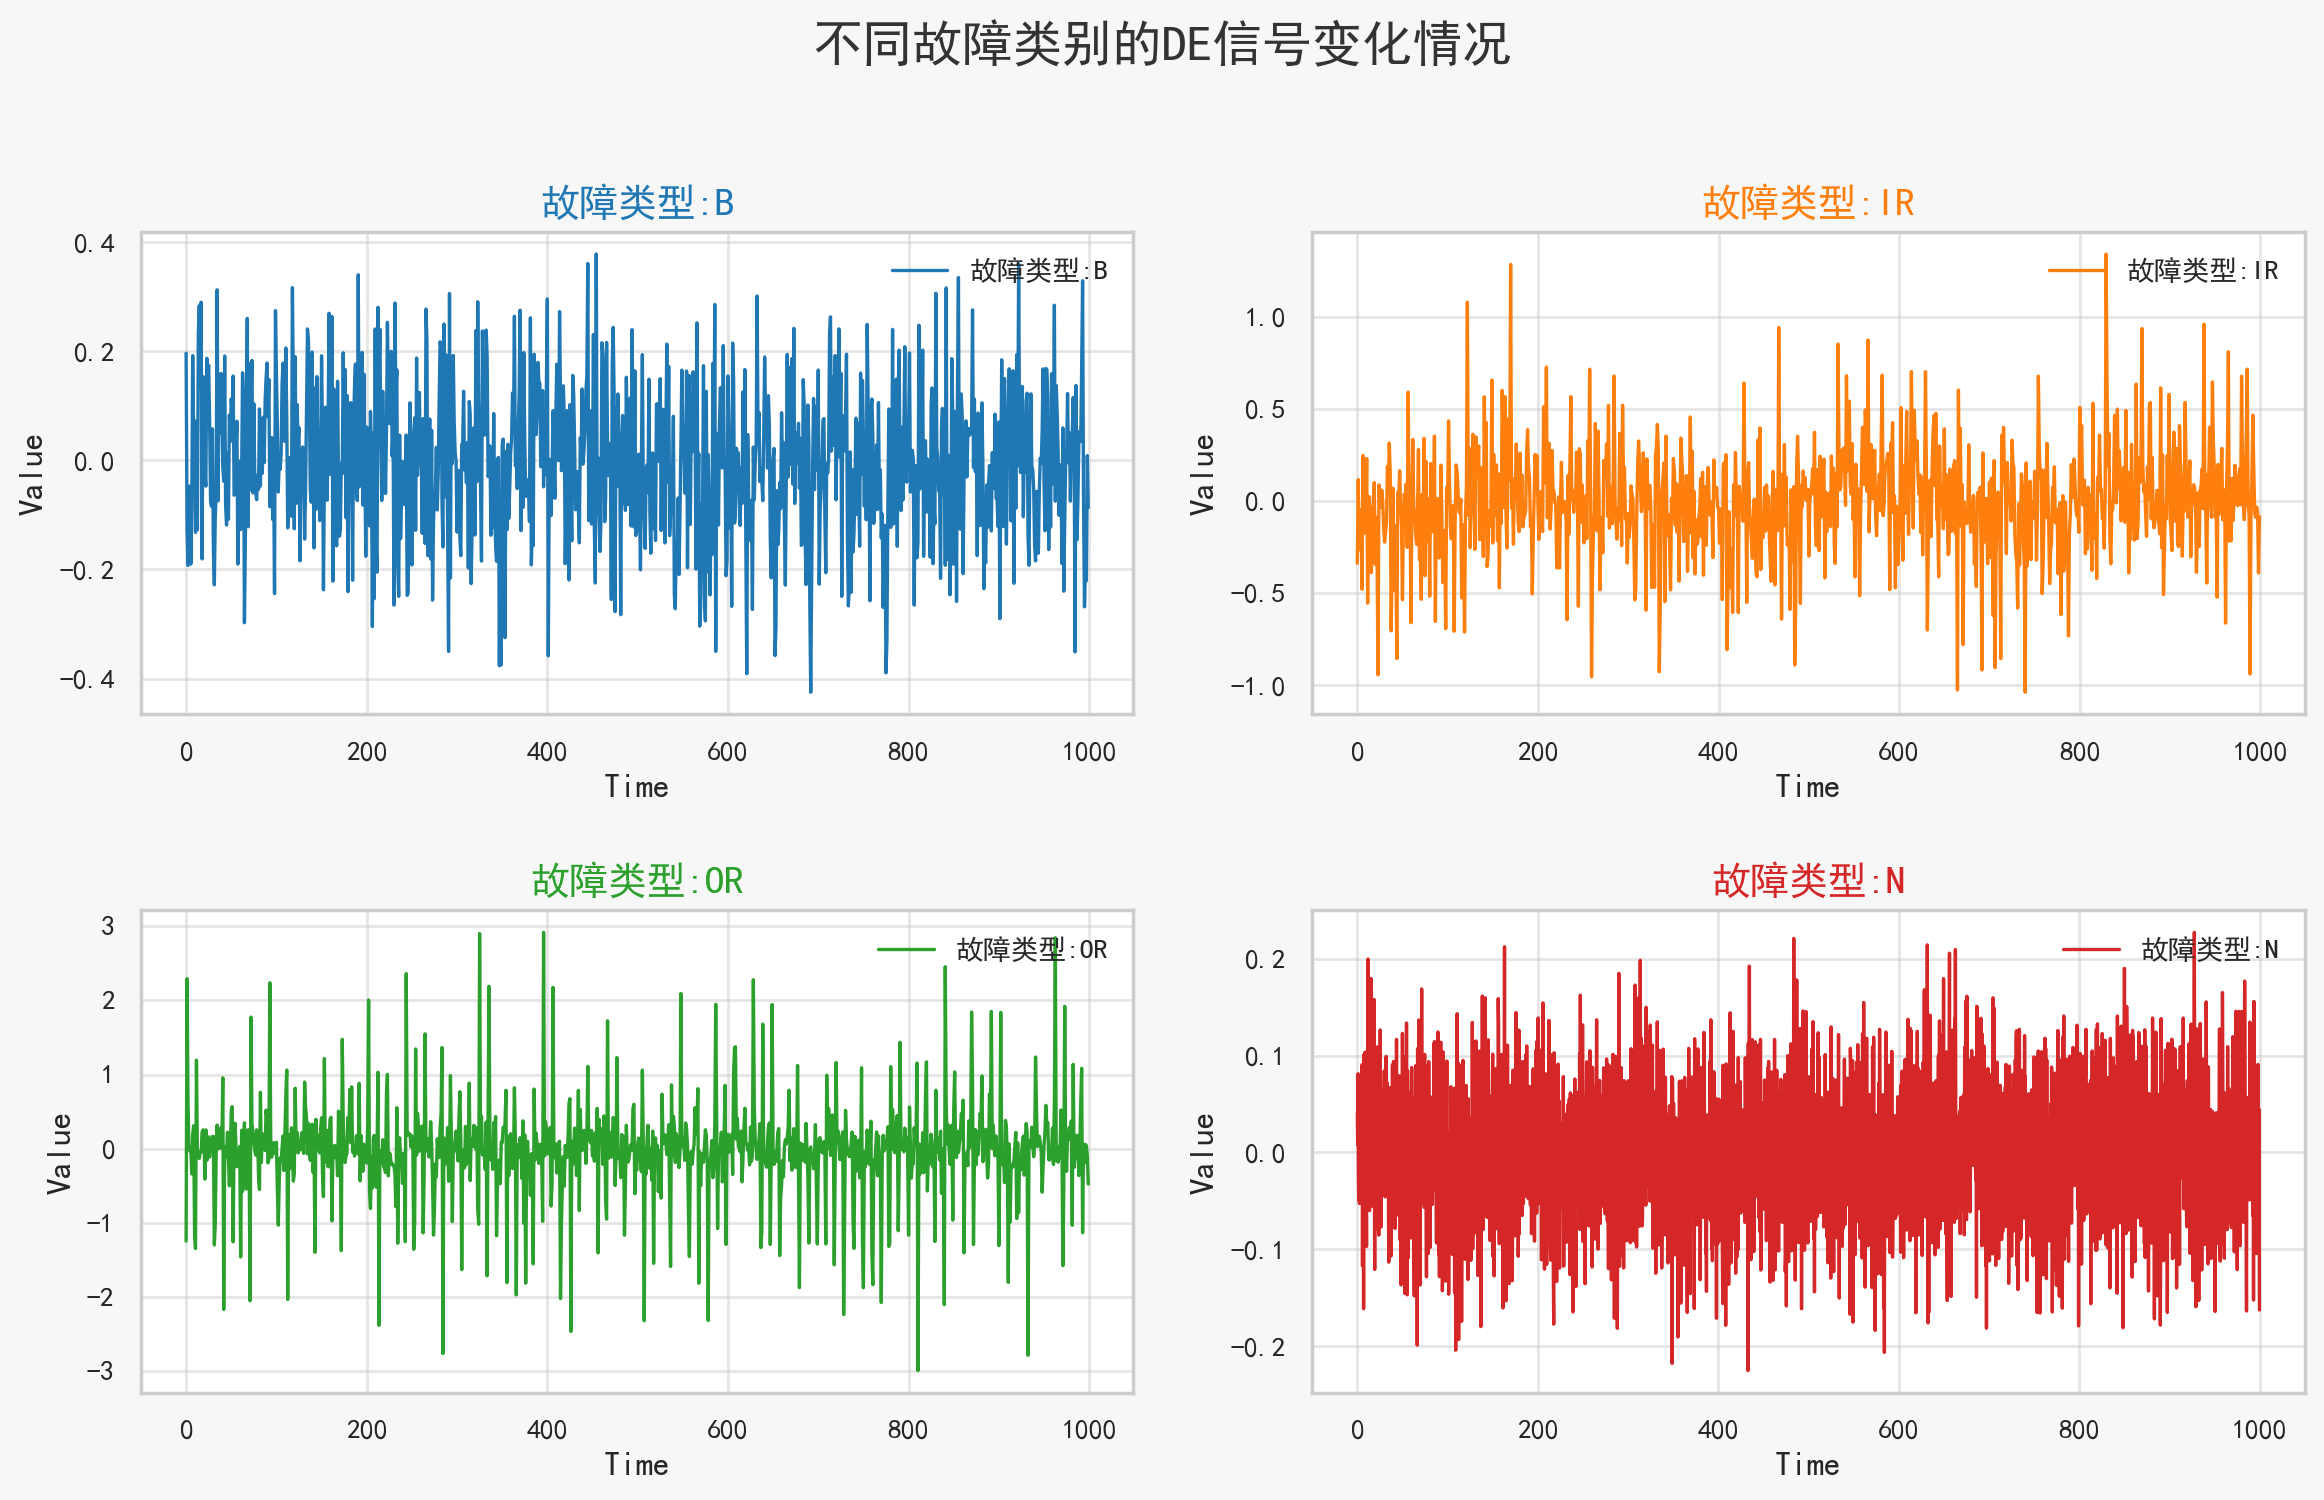

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# === 模拟不同长度的时间序列（x1~x4已经存在）
# ==========================
t1 = np.linspace(0, 1000, len(x1))
t2 = np.linspace(0, 1000, len(x2))
t3 = np.linspace(0, 1000, len(x3))
t4 = np.linspace(0, 1000, len(x4))

series = [
    (t1, x1, 'x1'),
    (t2, x2, 'x2'),
    (t3, x3, 'x3'),
    (t4, x4, 'x4')
]


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 自定义配色

# 下采样步长：可以根据数据稠密程度调整，比如10或20
step = 100

# ==========================
# 绘制 2×2 子图
# ==========================
fig, axs = plt.subplots(2, 2, figsize=(12, 8), facecolor='#f7f7f7')
fig.suptitle('不同故障类别的DE信号变化情况',
             fontsize=18, fontweight='bold', color='#333333', y=0.95)

for ax, (t, x, title), c, LABEL in zip(axs.flatten(), series, colors, ['B','IR','OR','N']):
    # ---- 直接在这里降采样 ----
    ax.plot(t[::step], x[::step], color=c, linewidth=1.2, label=f'故障类型:{LABEL}')
    ax.set_title(f'故障类型:{LABEL}', fontsize=14, fontweight='bold', color=c)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(True, which='major')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='major', labelsize=10, width=1.2)
    ax.tick_params(axis='both', which='minor', length=3, width=1.0)
    ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('问题1\\不同故障类别的DE信号变化情况.png',dpi=500,bbox_inches='tight')
plt.show()


可以看到,不同故障的信号值差别是非常大的

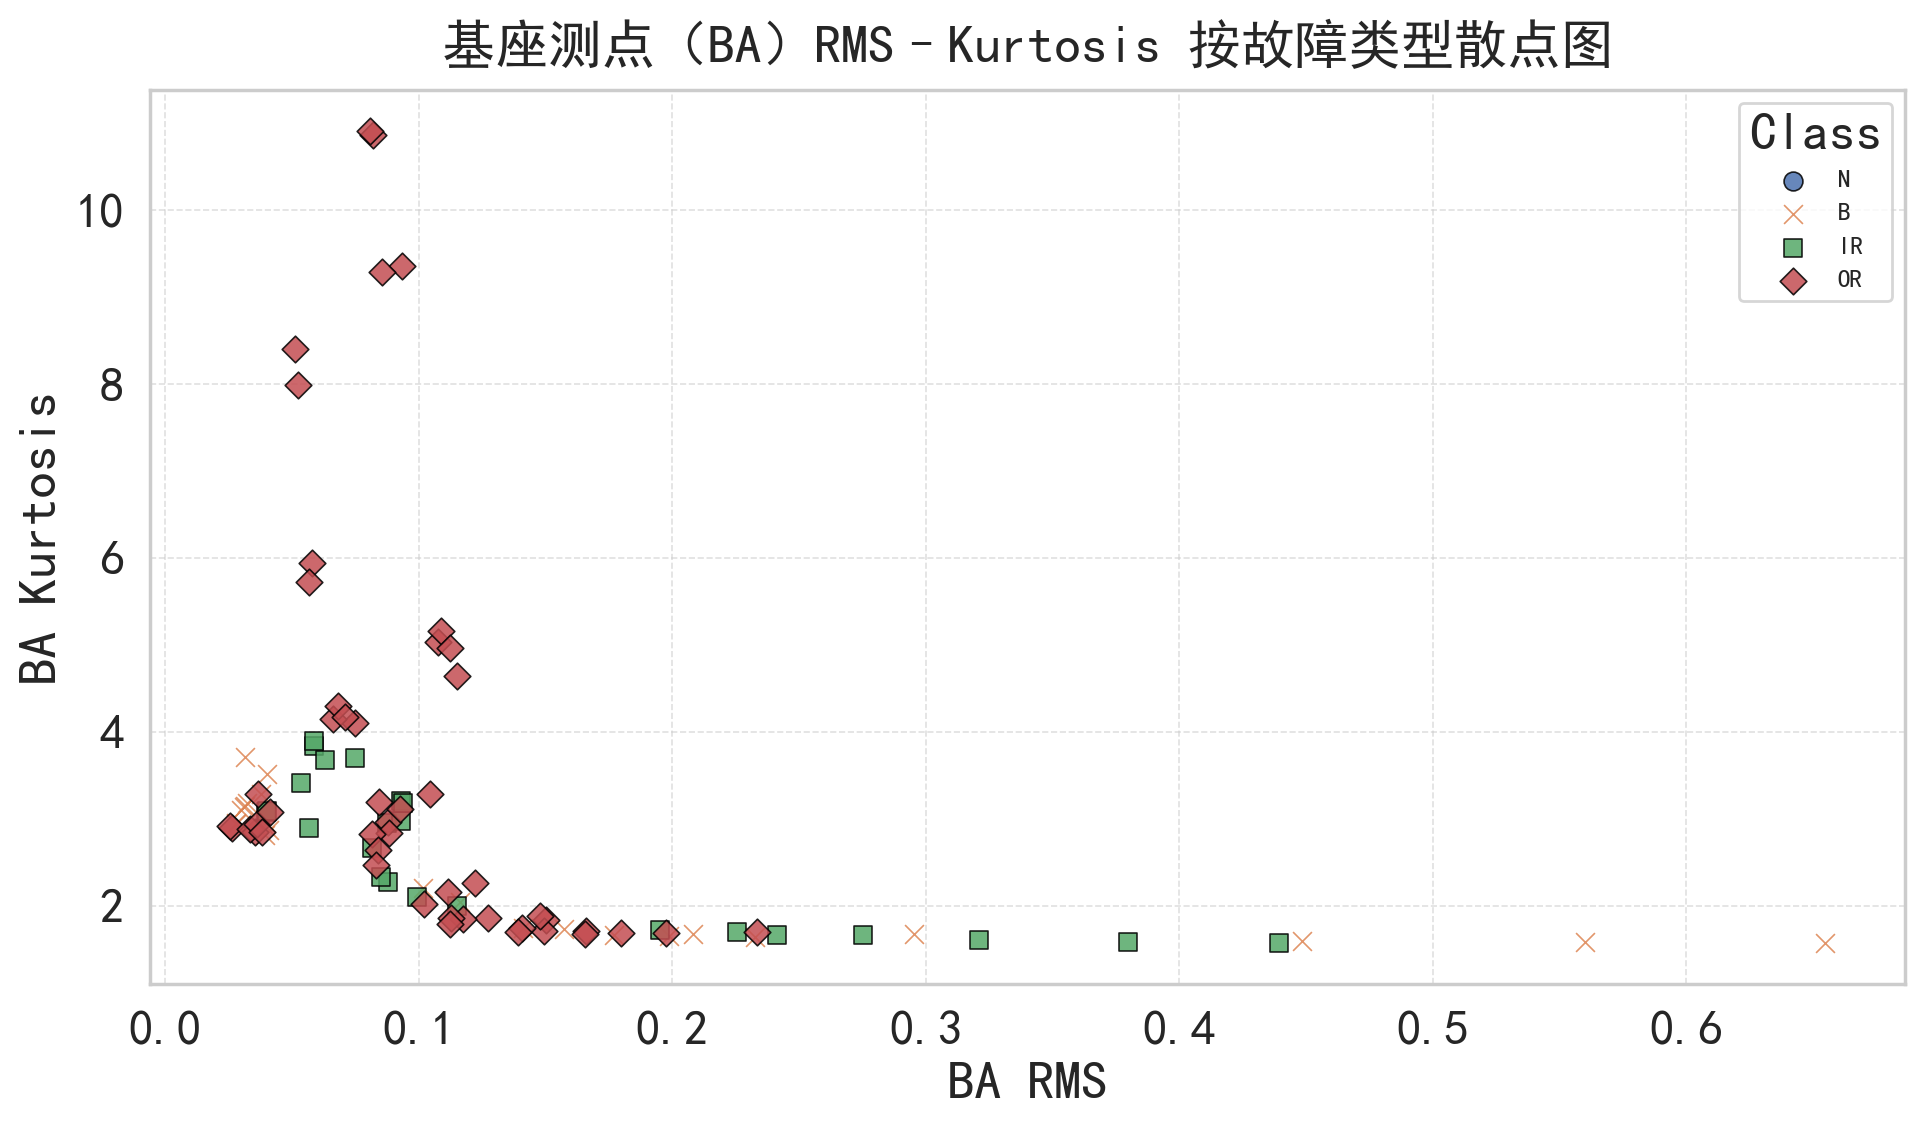

In [ ]:
# === 图 1：BA_RMS vs BA_Kurtosis（按类别上色）的散点图 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 读取数据
df = pd.read_csv('features_aggregated_perfile.csv')

# 2) 必要列检查
need_cols = ["label_cls", "BA_rms", "BA_kurtosis"]
for c in need_cols:
    if c not in df.columns:
        raise ValueError(f"缺少列：{c}")

# 3) 为不同类别指定标记与排序，颜色使用 matplotlib 默认循环色
label_order = ["N", "B", "IR", "OR"]  # 可调顺序
markers = {"N": "o", "B": "x", "IR": "s", "OR": "D"}  # 不同形状更易区分

plt.figure(figsize=(10, 6))

# 4) 分类别绘制
for lab in label_order:
    part = df[df["label_cls"] == lab]
    if len(part) == 0:
        continue
    plt.scatter(
        part["BA_rms"], part["BA_kurtosis"],
        s=46, alpha=0.85,
        marker=markers.get(lab, "o"),
        label=str(lab),
        linewidths=0.6, edgecolors="black"
    )

# 5) 视觉元素
plt.title("基座测点（BA）RMS–Kurtosis 按故障类型散点图", pad=10)
plt.xlabel("BA RMS")
plt.ylabel("BA Kurtosis")
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
plt.legend(title="Class", frameon=True, fontsize=9)
plt.tight_layout()

# 6) 可选：保存图片
#plt.savefig("问题1\\基座测点（BA）RMS–Kurtosis 按故障类型散点图.png",dpi=500,bbox_inches='tight')
plt.show()


用基座测点（BA）的能量指标 RMS 与脉冲性指标 Kurtosis 作为二维坐标，不同颜色/形状代表不同故障类型。若某一类样本在该平面形成相对集中的簇，说明 RMS×Kurtosis 的组合对该类具有较好的可分性。通常，早期缺陷会在相对较低的 RMS 下出现偏高的 Kurtosis（冲击明显但整体能量不一定大），而严重缺陷可能两者皆高。该图可用于直观评估单测点双特征的判别力，也有助于挑选后续分类模型的输入特征。

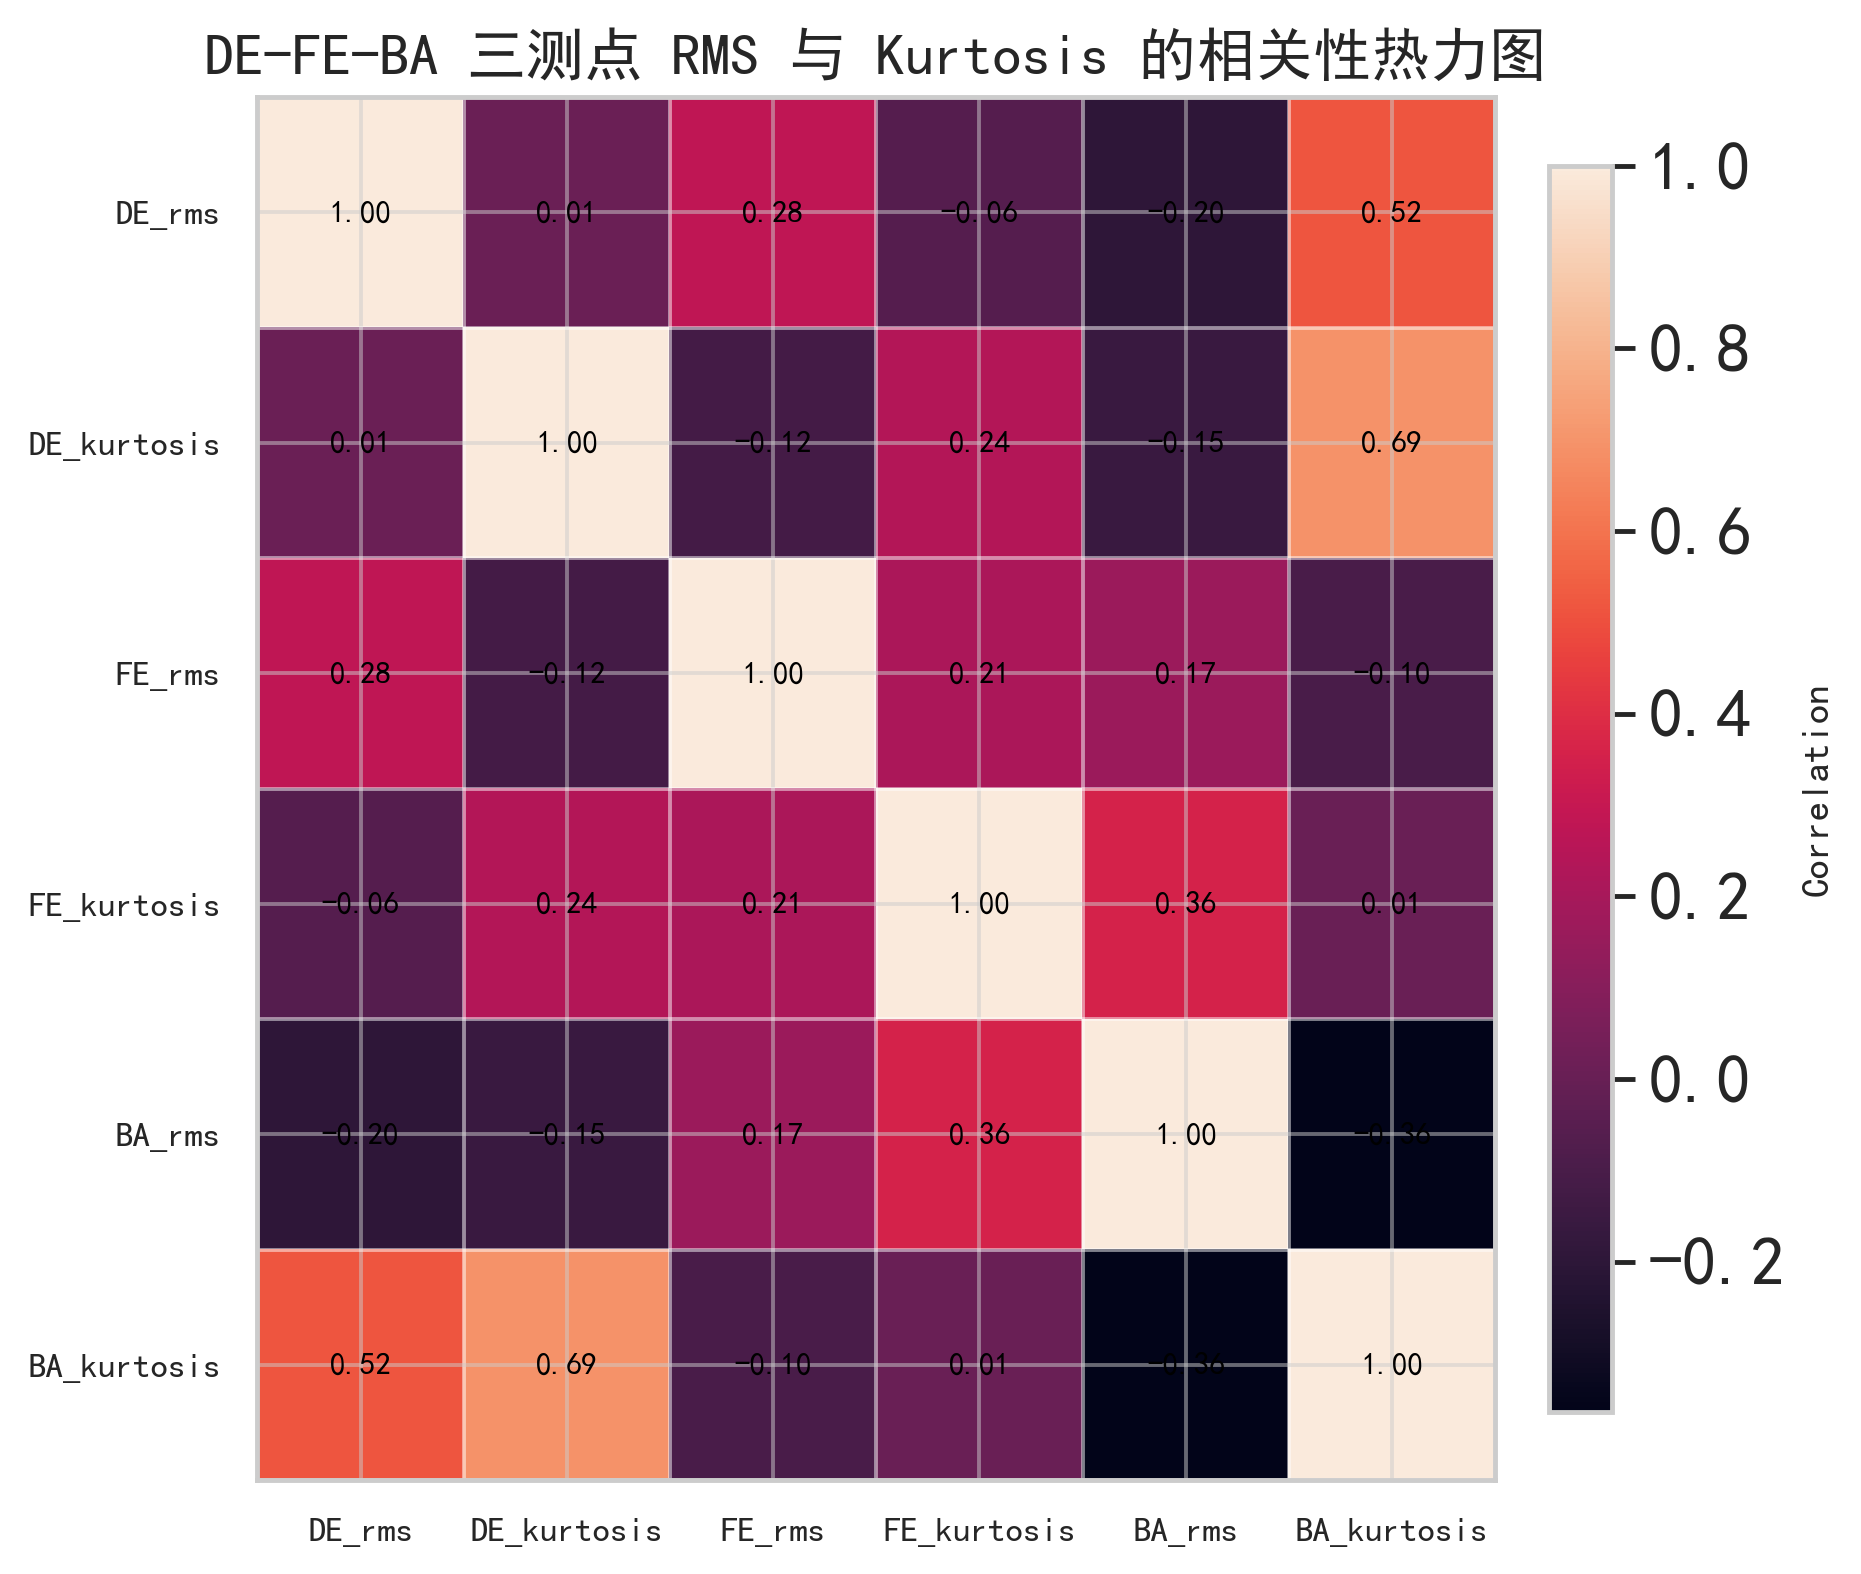

In [ ]:
# === 图 2：RMS 与 Kurtosis（DE/FE/BA）的相关性热力图 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# 2) 选择要计算相关性的特征
feat = ["DE_rms", "DE_kurtosis", "FE_rms", "FE_kurtosis", "BA_rms", "BA_kurtosis"]
corr = df[feat].corr().values

fig, ax = plt.subplots(figsize=(7, 6), dpi=140)

im = ax.imshow(corr, interpolation="nearest", aspect="auto")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Correlation", rotation=90, fontsize=10)

ax.set_xticks(np.arange(len(feat)))
ax.set_yticks(np.arange(len(feat)))
ax.set_xticklabels(feat, rotation=0, ha="center", fontsize=9)   # ← 缩小字体
ax.set_yticklabels(feat, fontsize=9)                            # ← 缩小字体

# 网格与注释
ax.set_xticks(np.arange(-0.5, len(feat), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(feat), 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=1.0)
ax.tick_params(which="minor", bottom=False, left=False)

for i in range(len(feat)):
    for j in range(len(feat)):
        ax.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center",
                fontsize=8, color="black")  # 数值字体也调小

ax.set_title("DE-FE-BA 三测点 RMS 与 Kurtosis 的相关性热力图",size=15)
plt.tight_layout()

# 4) 可选：保存图片
#plt.savefig("问题1\\DE-FE-BA 三测点 RMS 与 Kurtosis 的相关性热力图.png",dpi=500,bbox_inches='tight')
plt.show()


热力图展示 DE、FE、BA 三个测点的 RMS 与 Kurtosis 两类特征之间的皮尔逊相关性。对角线为 1；颜色越接近 1（红/暖）表示正相关显著，越接近 -1（蓝/冷）表示负相关显著。

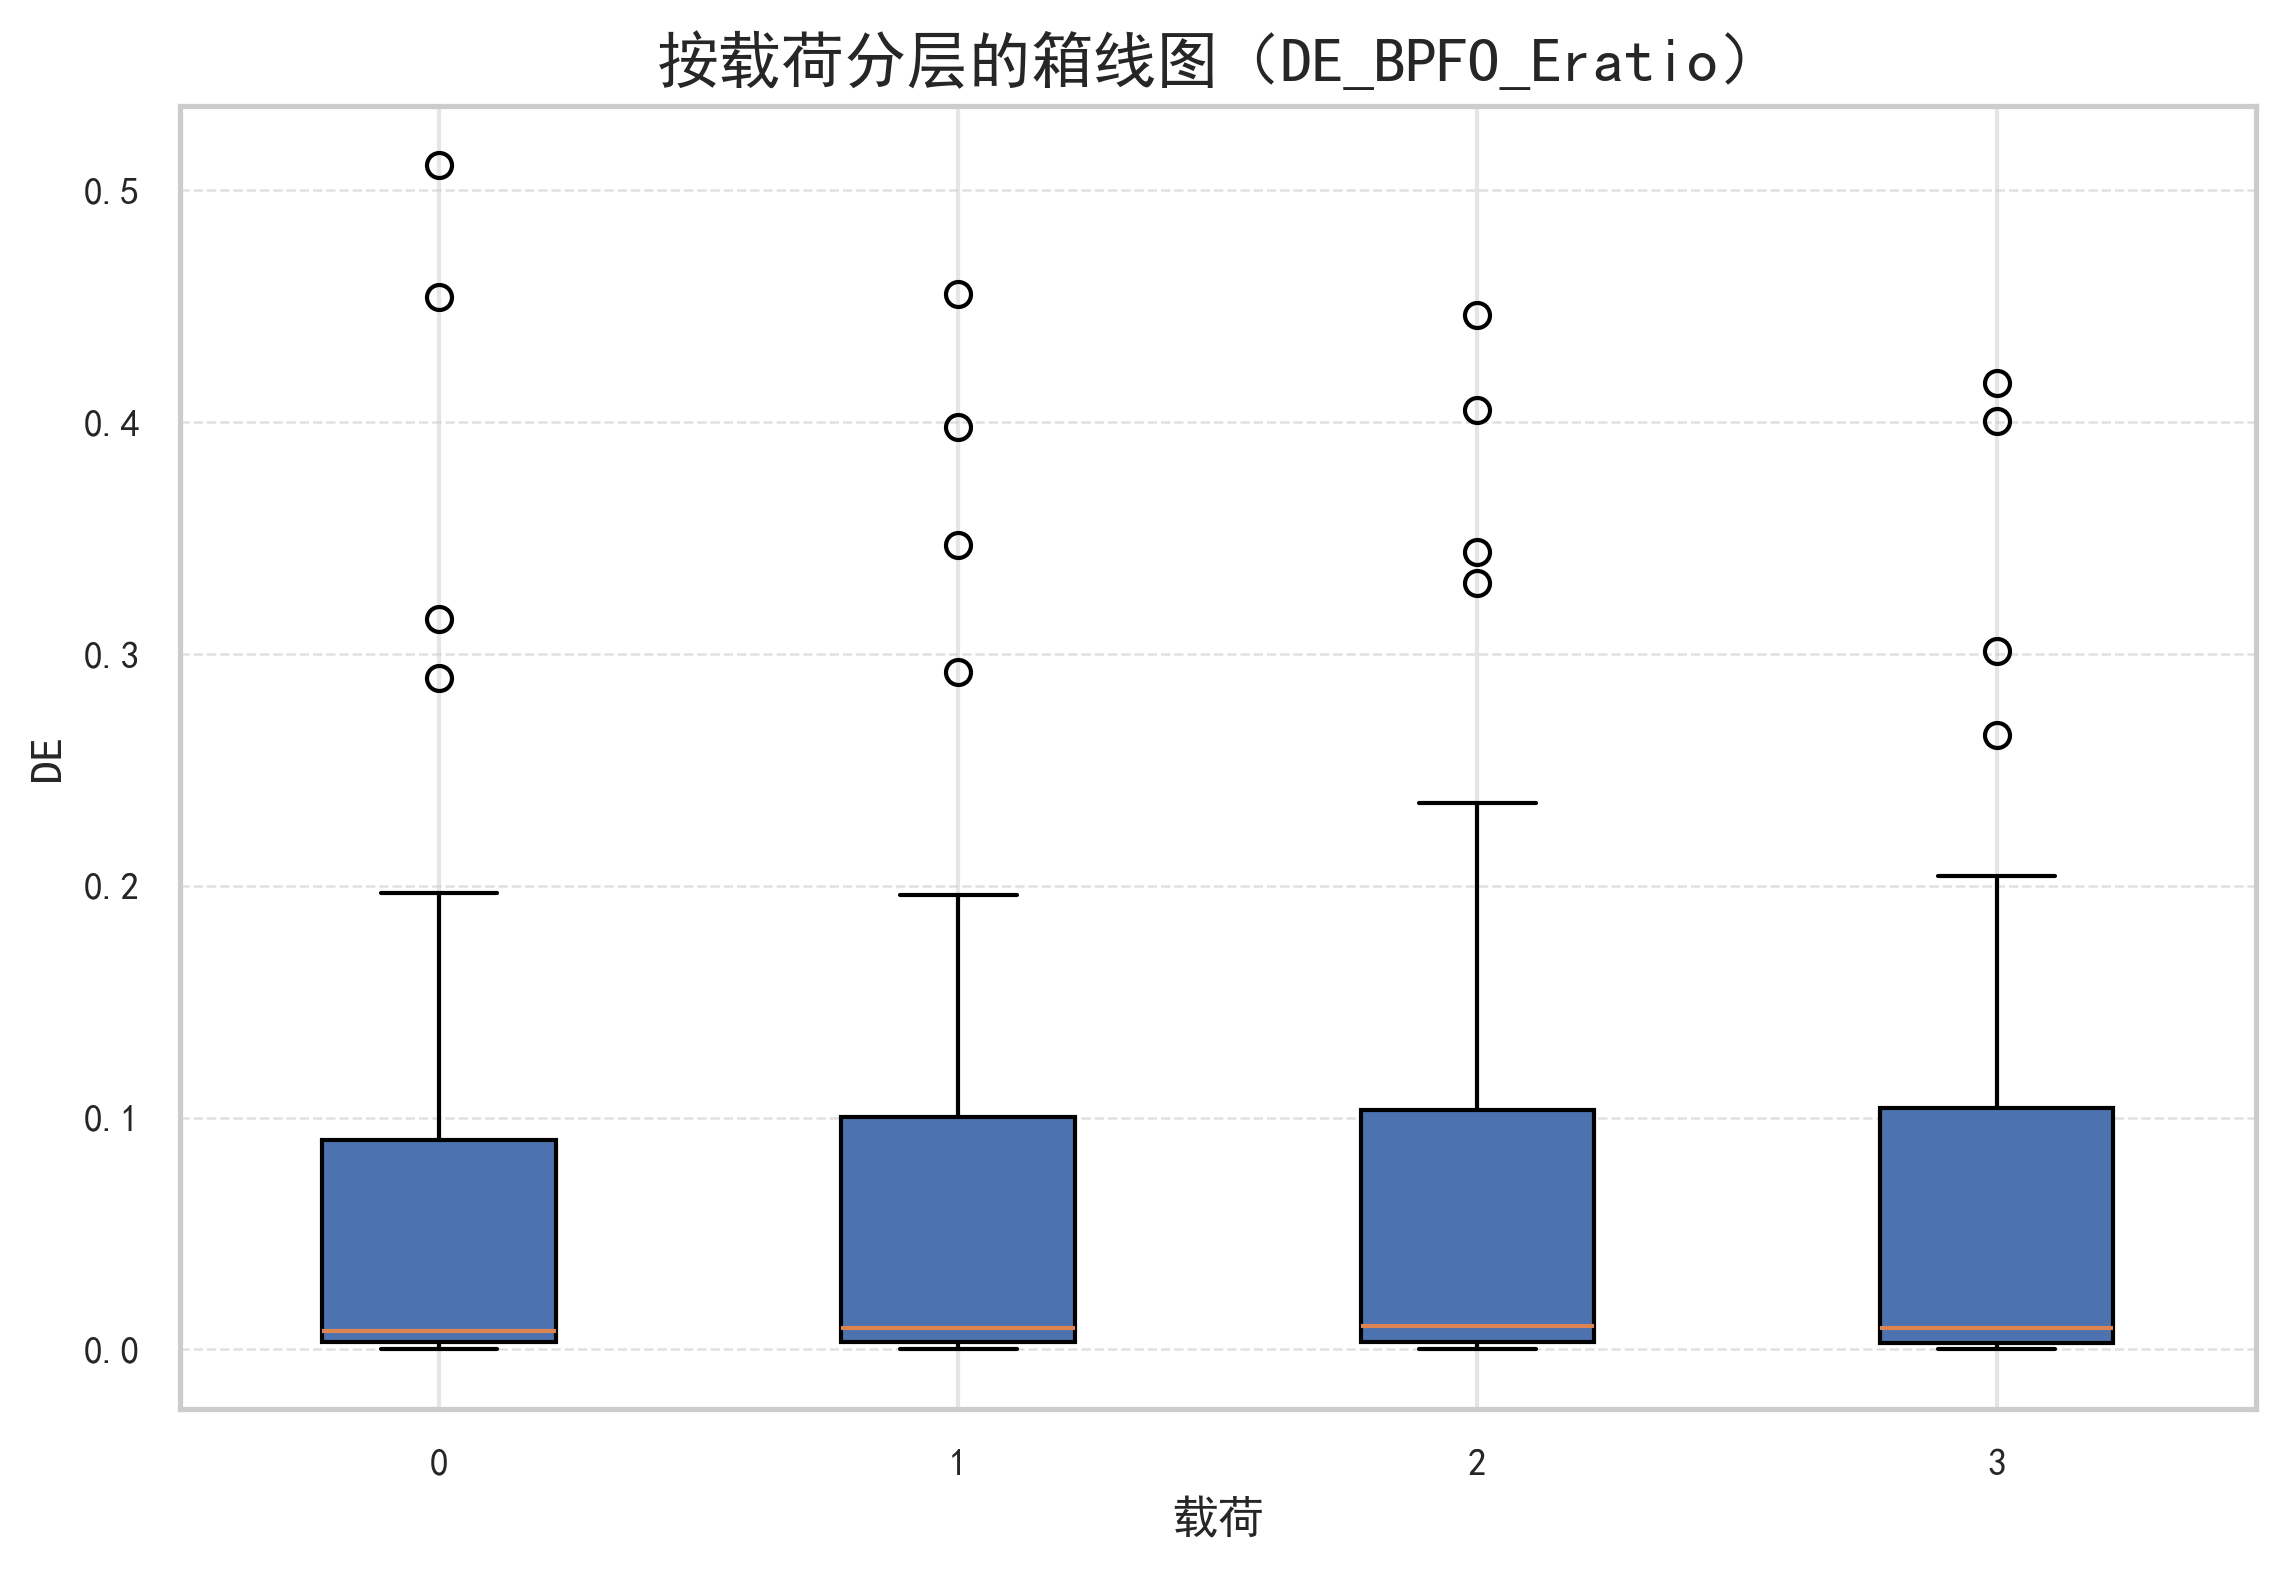

In [ ]:
need_cols = ["label_load_hp", "DE_BPFO_Eratio"]
for c in need_cols:
    if c not in df.columns:
        raise ValueError(f"缺少列：{c}")

# 按载荷顺序整理数据
loads = sorted([int(x) for x in df["label_load_hp"].unique() if pd.notnull(x)])
data_by_load = [df[df["label_load_hp"]==hp]["DE_BPFO_Eratio"].dropna().values for hp in loads]

plt.figure(figsize=(8,5.6), dpi=150)
plt.boxplot(data_by_load, labels=[str(hp) for hp in loads], patch_artist=True)

plt.title("按载荷分层的箱线图（DE_BPFO_Eratio）",size=15)
plt.xlabel("载荷", fontsize=11)
plt.ylabel("DE", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
plt.tight_layout()
#plt.savefig("问题1\\按载荷分层的箱线图（DE_BPFO_Eratio）.png",dpi=500,bbox_inches='tight')
plt.show()

按载荷分层的小提琴图（DE_BPFO_Eratio）

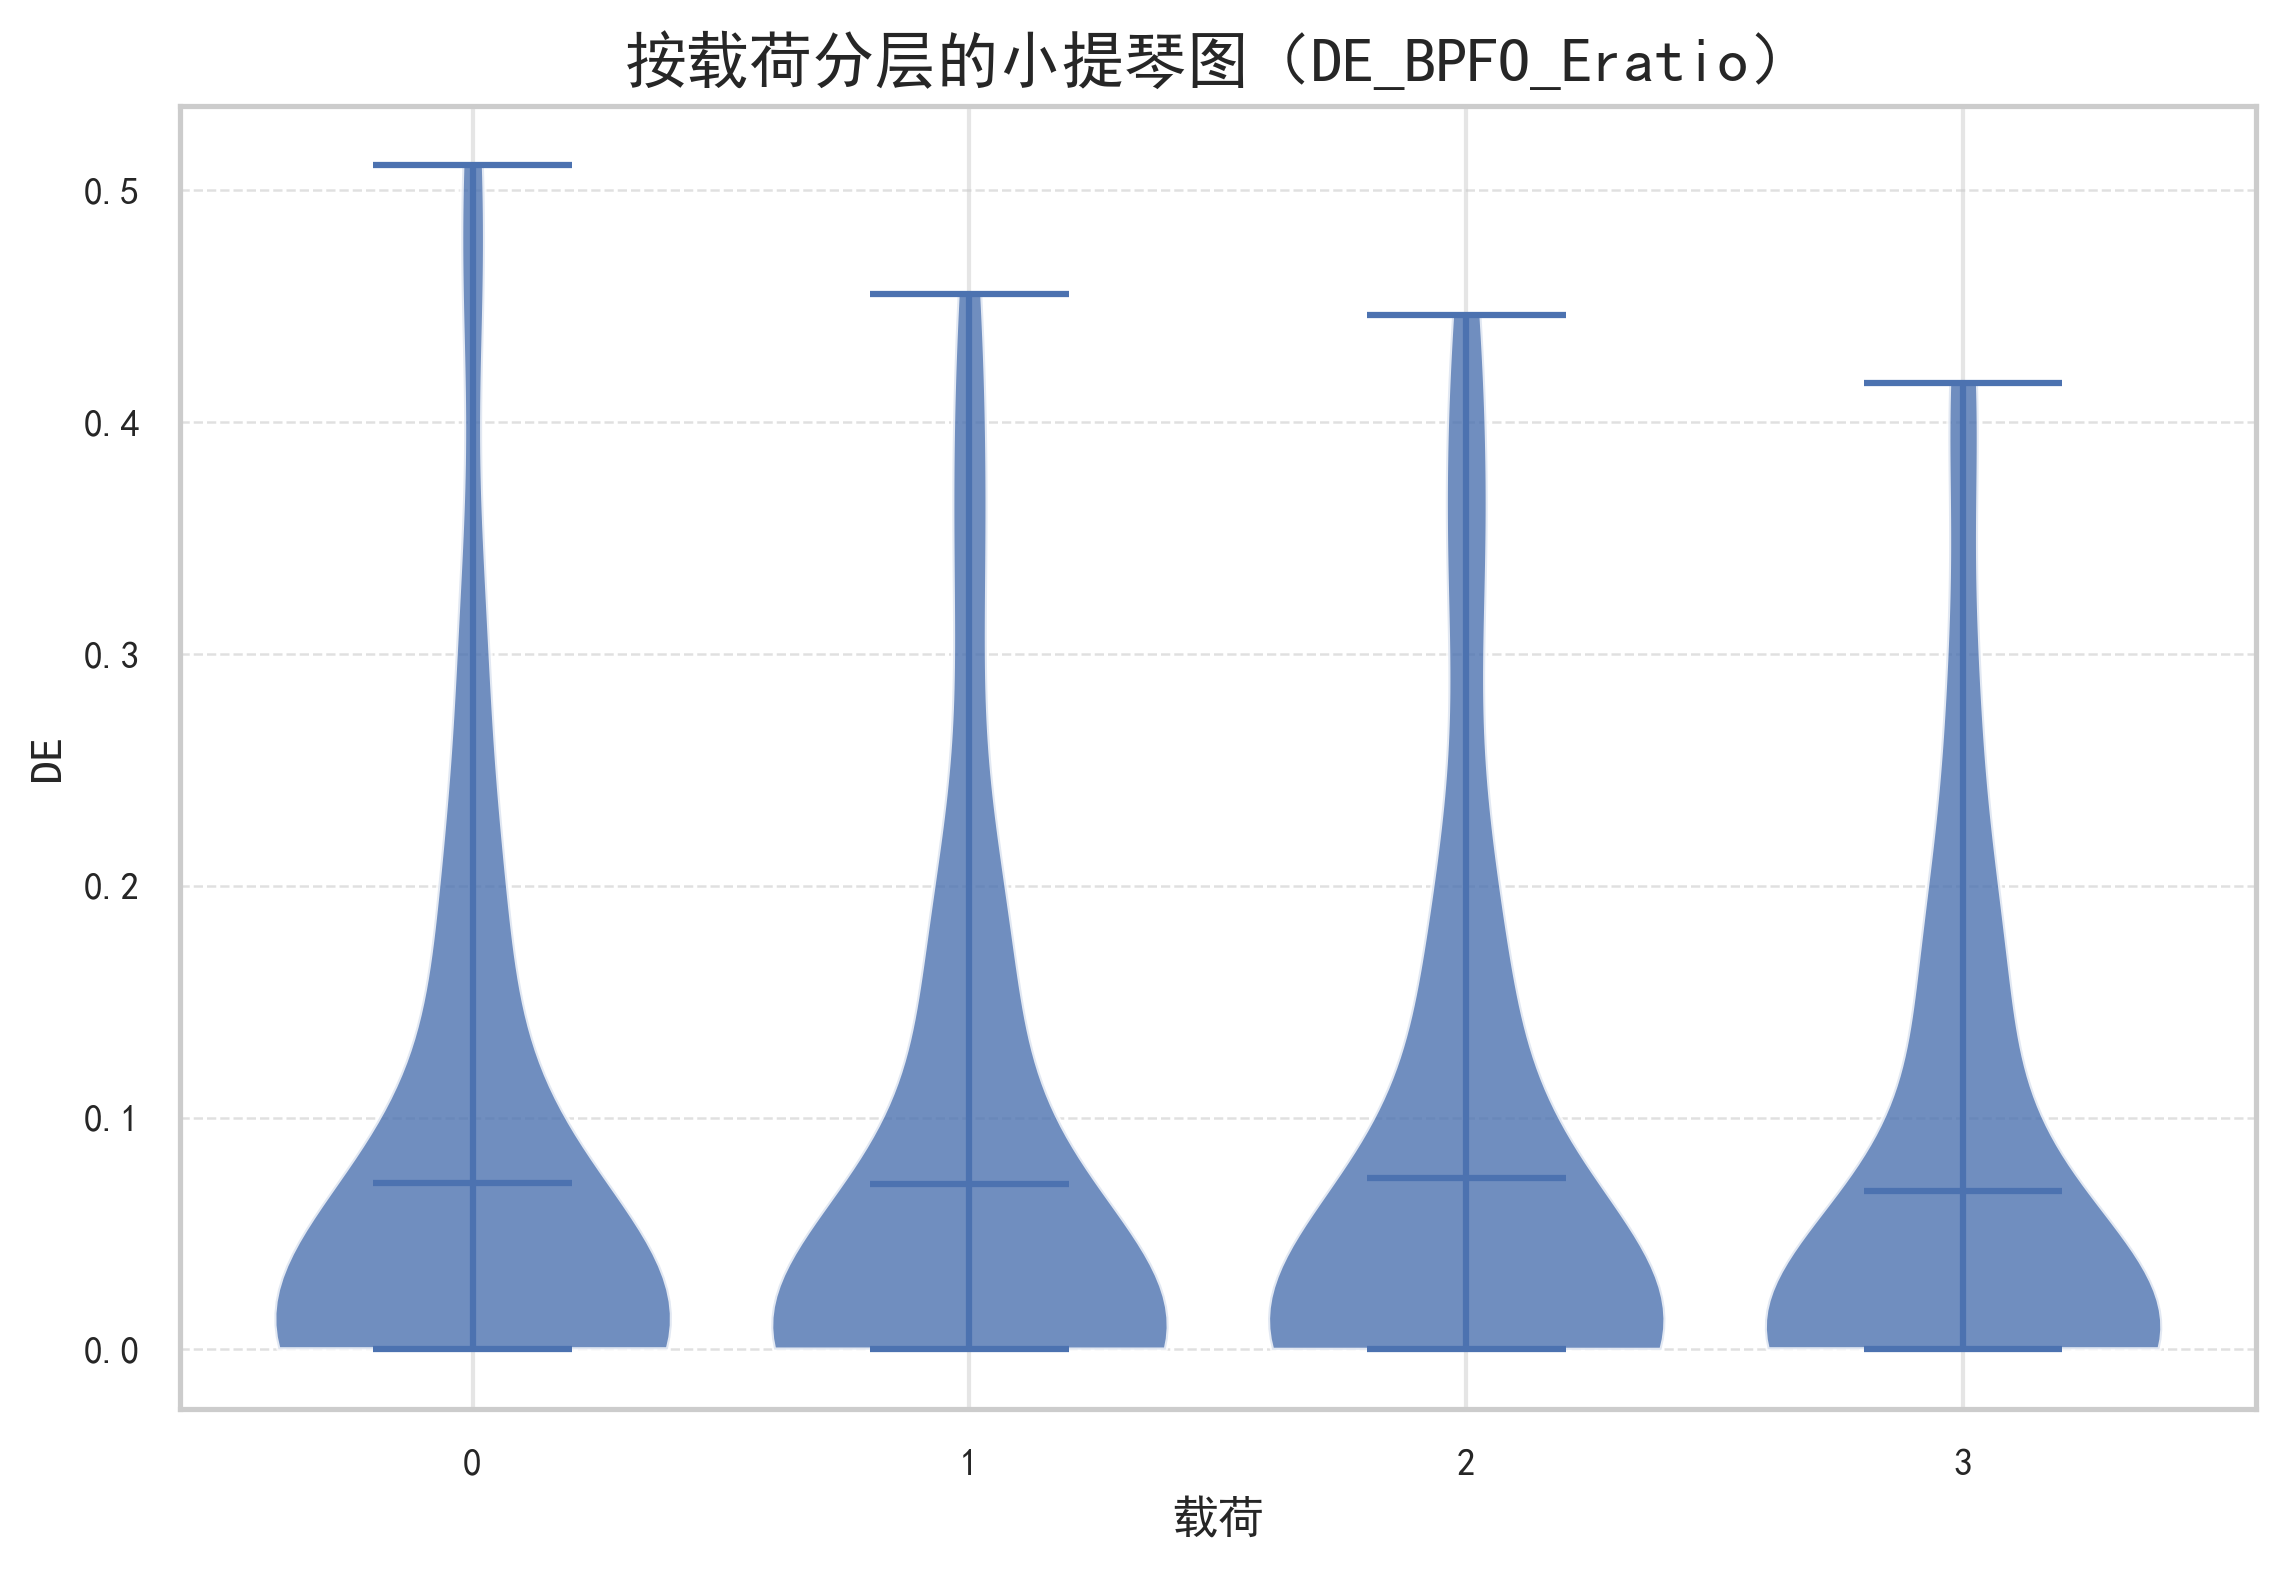

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5.6), dpi=150)
vi = plt.violinplot(data_by_load, showmeans=True, showextrema=True, widths=0.8)

# 美化：可根据需要调色
for b in vi['bodies']:
    b.set_alpha(0.8)

plt.title("按载荷分层的小提琴图（DE_BPFO_Eratio）",size=15)
plt.xlabel("载荷", fontsize=11)
plt.ylabel("DE", fontsize=11)
plt.xticks(ticks=np.arange(1, len(loads)+1), labels=[str(hp) for hp in loads], fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
plt.tight_layout()
#plt.savefig("问题1\\按载荷分层的小提琴图（DE_BPFO_Eratio）.png",dpi=500,bbox_inches='tight')
plt.show()
